# **HYBRID MODEL FOR CHURN PREDICTION WITH EXPLAINABLE AI**

In [ ]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [ ]:
# Read in full sparkify dataset
event_data = "/content/mini_sparkify_event_data.json"
df = spark.read.json(event_data)

# Load and Clean Dataset

In this notebook, the file name, `mini_sparkify_event_data.json`, will be loaded and cleaned such as handling of invalid or missing values.

The first five rows of the dataset.

In [ ]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

Schema information

* artist: Artist name (ex. Daft Punk)
* auth: User authentication status (ex. Logged)
* firstName: User first name (ex. Colin)
* gender: Gender (ex. F or M)
* itemInSession: Item count in a session (ex. 52)
* lastName: User last name (ex. Freeman)
* length: Length of song (ex. 223.60771)
* level: User plan (ex. paid)
* location: User's location (ex. Bakersfield)
* method: HTTP method (ex. PUT)
* page: Page name (ex. NextSong)
* registration: Registration timestamp (unix timestamp) (ex. 1538173362000)
* sessionId: Session ID (ex. 29)
* song: Song (ex. Harder Better Faster Stronger)
* status: HTTP status (ex. 200)
* ts: Event timestamp(unix timestamp) (ex. 1538352676000)
* userAgent: User's browswer agent (ex. Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0)
* userId: User ID (ex. 30)

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Statistics

Statistics of the whole dataset

In [ ]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

Statistics of the `artist` column

In [ ]:
df.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



Statistics of the `sessionId` column

In [ ]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630783|
|    min|                1|
|    max|             2474|
+-------+-----------------+



Statistics of the `userId` column

In [ ]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910527|
|    min|                  |
|    max|                99|
+-------+------------------+



Total rows: 286,500

In [ ]:
df.count()

286500

All the `page` events in the dataset:

- About
- Add Friend
- Add to Playlist
- Cancel
- Cancellation Confirmation: **This even wil be used as a flag of churn**
- Downgrade
- Error
- Help
- Home
- Login
- Logout
- NextSong
- Register
- Roll Advert
- Save Settings
- Settings
- Submit Downgrade
- Submit Registration
- Submit Upgrade
- Thumbs Down
- Thumbs Up
- Upgrade

`page` kind

In [ ]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



## missing values

In [ ]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.

    This function is useful because the data can be either three cases below:

    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

Check how many missing values in each column

In [ ]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


`userId` and `sessionId`

If the below Ids are null or empty, delete those rows:

* userId
* sessionId

In [ ]:
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_without_missing_id = df_without_missing_id.filter(df["userId"] != "") # `userId` should not be empty string

In [ ]:
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_without_missing_id.count())) # no missing values

if df.count() == df_without_missing_id.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

df:                    286500
df_without_missing_id: 278154
8346 rows have been removed.


# Exploratory Data Analysis

Detect number columns and category columns.

* num_cols: Number columns (Long or Double)
* cat_cols: Category columns (String)

In [ ]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)

    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [ ]:
num_cols

[]

In [ ]:
cat_cols

[]

## Number columns

In [ ]:
df_without_missing_id.describe(num_cols).show()

+-------+------------------+---------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+---------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|            228108|278154|           278154|278154| 278154|      

There are three HTTP status codes:

* 307: Temporary Redirect
* 404: Not Found
* 200: OK

In [ ]:
df_without_missing_id.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



### Category columns

auth

In [ ]:
df_without_missing_id.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



gender

In [ ]:
df_without_missing_id.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



level

In [ ]:
df_without_missing_id.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



location (only showing top 10)

In [ ]:
df_without_missing_id.select("location").dropDuplicates().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Kingsport-Bristol...|
|New Haven-Milford...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
+--------------------+
only showing top 10 rows



method

In [ ]:
df_without_missing_id.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



page

In [ ]:
df_without_missing_id.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



userAgent (only showing top 10)

In [ ]:
df_without_missing_id.select("userAgent").dropDuplicates().show(10)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (iPh...|
+--------------------+
only showing top 10 rows



### Define Churn

Churn will be defined as when `Cancellation Confirmation` events happen, and users with the events are churned users in this analysis.

churn: `Cancellation Confirmation`

In [ ]:
df_without_missing_id.filter("page = 'Cancellation Confirmation'").show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  NULL|Cancelled|   Adriel|     M|          104| Mendoza|  NULL| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|NULL|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  NULL|Cancelled|    Diego|     M|           56|   Mckee|  NULL| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|NULL|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  NU

In [ ]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = df_without_missing_id.withColumn("churned", flag_churned_event("page"))

churned rate (from total event logs)

In [ ]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [ ]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|    30|     M| paid|       NextSong|   200|1538352117000|      0|
|     9|     M| free|       NextSong|   200|1538352180000|      0|
|    30|     M| paid|       NextSong|   200|1538352394000|      0|
|     9|     M| free|       NextSong|   200|1538352416000|      0|
|    30|     M| paid|       NextSong|   200|1538352676000|      0|
|     9|     M| free|       NextSong|   200|1538352678000|      0|
|     9|     M| free|       NextSong|   200|1538352886000|      0|
|    30|     M| paid|       NextSong|   200|1538352899000|      0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|      0|
|    30|     M| paid|       NextSong|   200|1538353084000|      0|
|     9|     M| free|       NextSong|   200|1538353146000|      0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    

In [ ]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [ ]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+---------------+------+-------------+-------+-----+-----+
|userId|gender|level|           page|status|           ts|churned|phase|churn|
+------+------+-----+---------------+------+-------------+-------+-----+-----+
|   100|     M| paid|       NextSong|   200|1538492662000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538492899000|      0|    0|    0|
|   100|     M| paid|    Thumbs Down|   307|1538492900000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493138000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493545000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493817000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493984000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538494349000|      0|    0|    0|
|   100|     M| paid|Add to Playlist|   200|1538494374000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|15384946

In [ ]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+----------+------+-------------+-------+-----+-----+
|userId|gender|level|      page|status|           ts|churned|phase|churn|
+------+------+-----+----------+------+-------------+-------+-----+-----+
|100005|     M| free|      Home|   200|1538407015000|      0|    0|    1|
|100005|     M| free|  NextSong|   200|1538407016000|      0|    0|    1|
|100005|     M| free| Thumbs Up|   307|1538407017000|      0|    0|    1|
|100005|     M| free|  NextSong|   200|1538407330000|      0|    0|    1|
|100005|     M| free|  NextSong|   200|1538407583000|      0|    0|    1|
|100005|     M| free|  NextSong|   200|1538407760000|      0|    0|    1|
|100005|     M| free|  NextSong|   200|1538408020000|      0|    0|    1|
|100005|     M| free|  NextSong|   200|1538408253000|      0|    0|    1|
|100005|     M| free|   Upgrade|   200|1538408286000|      0|    0|    1|
|100005|     M| free|Add Friend|   307|1538408287000|      0|    0|    1|
|100005|     M| free|  NextSong|   200

52 userIds were churned

In [ ]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


### Explore Data

In this section, data exploration will be done comparing churned users with not churned users, inspecting if there are any big differences between the two groups.

The below columns will be examined:

* artist
  * [x] the number of artist
* [x] gender: 0 or 1
* length
  * [x] the total length
* [x] level: 0 or 1
* page
  * [x] the number of `Thumbs Up`
  * [x] the number of `Thumbs Down`
* song
  * [x] the number of song

Define a common function to convert churn value (0 or 1) to `Not Churn` or `Churn`

Both matplotlib and seaborn plot libraries require pandas dataframe, not pyspark dataframe, so I need to convert the pyspark dataframe to pandas one. I do this conversion every time for a small subset of the dataset because if I do this conversion for all the dataset, it takes time and causes an error.

In [ ]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [ ]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

gender

In [ ]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,10,M,Not Churn
1,10,M,Not Churn
2,10,M,Not Churn
3,10,M,Not Churn
4,10,M,Not Churn


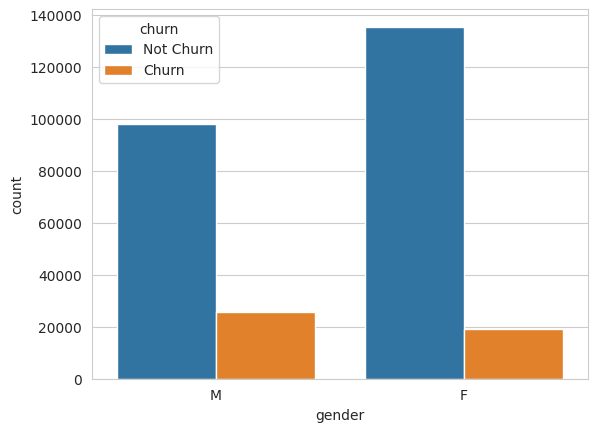

In [ ]:
sns.countplot(x="gender", hue="churn", data=pd_gender);

level

In [ ]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()

,userId,level,churn
0,10,paid,Not Churn
1,10,paid,Not Churn
2,10,paid,Not Churn
3,10,paid,Not Churn
4,10,paid,Not Churn


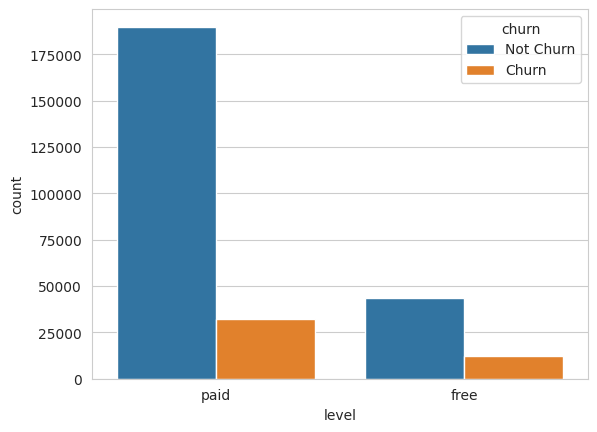

In [ ]:
sns.countplot(x="level", hue="churn", data=pd_level);

artist

In [ ]:
pd_artist = df_churn_user.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_artist.head()

,userId,churn,artist_count
0,125,Churn,8
1,51,Churn,2111
2,124,Not Churn,4079
3,7,Not Churn,150
4,54,Churn,2841


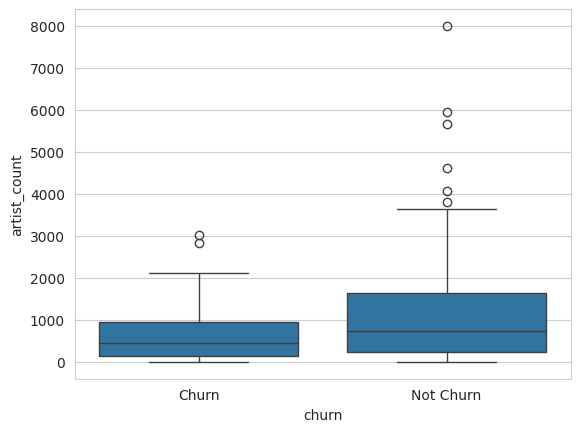

In [ ]:
sns.boxplot(x="churn", y="artist_count", data=pd_artist);

song

In [ ]:
pd_song = df_churn_user.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", func_churn_label("churn")).toPandas()
pd_song.head()

,userId,churn,song_count
0,125,Churn,8
1,51,Churn,2111
2,124,Not Churn,4079
3,7,Not Churn,150
4,54,Churn,2841


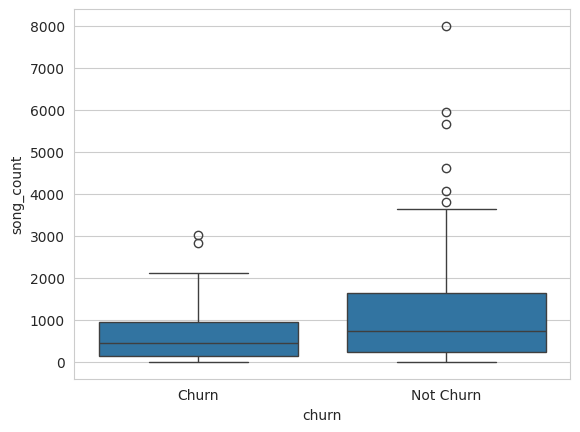

In [ ]:
sns.boxplot(x="churn", y="song_count", data=pd_song);

length

In [ ]:
pd_length = df_churn_user.join(df_churn.groupby("userId") \
                                       .agg({"length": "sum"}) \
                                       .withColumnRenamed("sum(length)", "total_length"), ["userId"]) \
                          .withColumn("churn", func_churn_label("churn")).toPandas()
pd_length.head()

,userId,churn,total_length
0,125,Churn,2.089113e+03
1,51,Churn,5.232758e+05
2,124,Not Churn,1.012312e+06
3,7,Not Churn,3.803409e+04
4,54,Churn,7.113449e+05


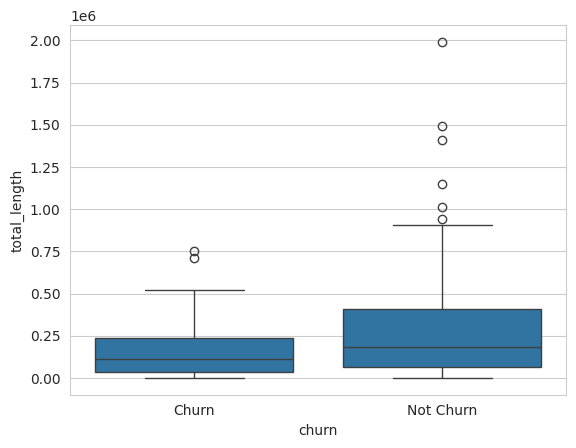

In [ ]:
sns.boxplot(x="churn", y="total_length", data=pd_length);

page: total visits

In [ ]:
pd_visit = df_churn_user.join(df_churn.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_visit.head()

,userId,churn,visit_count
0,125,Churn,11
1,51,Churn,2464
2,124,Not Churn,4825
3,7,Not Churn,201
4,54,Churn,3437


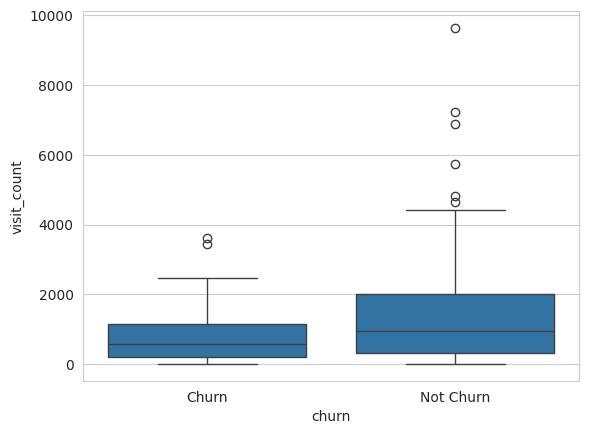

In [ ]:
sns.boxplot(x="churn", y="visit_count", data=pd_visit);

page: Thumbs Up / Thumbs Down

up

In [ ]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_up.head()

,userId,churn,up_count
0,51,Churn,100
1,124,Not Churn,171
2,7,Not Churn,7
3,54,Churn,163
4,15,Not Churn,81


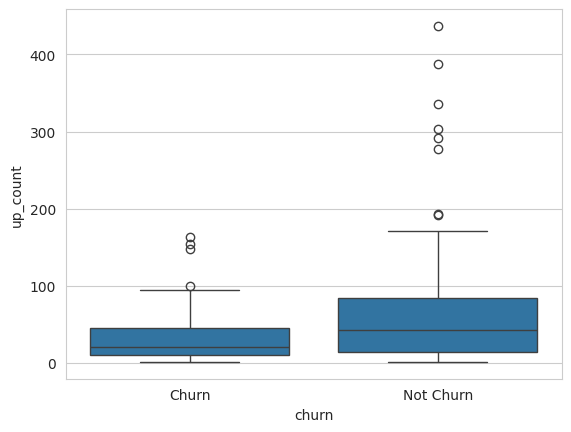

In [ ]:
sns.boxplot(x="churn", y="up_count", data=pd_up);

down

In [ ]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_down.head()

,userId,churn,down_count
0,51,Churn,21
1,124,Not Churn,41
2,7,Not Churn,1
3,15,Not Churn,14
4,54,Churn,29


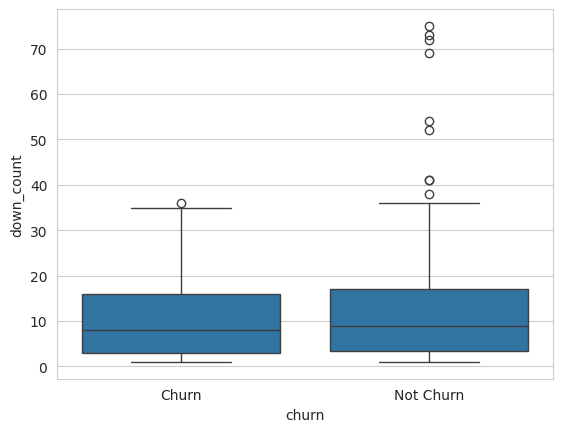

In [ ]:
sns.boxplot(x="churn", y="down_count", data=pd_down);

# Feature Engineering

### Feature Engineering Ideas

* artist
  * [x] the number of artist
* [x] gender: 0 or 1
* length
  * [x] the total length
* [x] level: 0 or 1
* page
  * [x] the number of `Thumbs Up`
  * [x] the number of `Thumbs Down`
* song
  * [x] the number of song

In [ ]:
df_churn.show(1)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-------+-----+-----+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|            song|status|           ts|           userAgent|userId|churned|phase|churn|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-------+-----+-----+
|Evanescence|Logged In|    Colin|     M|            0|  Larson|237.11302| paid|Dallas-Fort Worth...|   PUT|NextSong|1537982255000|      256|Bring Me To Life|   200|1538492662000|Mozilla/5.0 (Wind...|   100|      0|    0|    0|
+-----------+---------+---------+------+-------------+--------+---------+-----+-------------

Original dataframe to be merged later

In [ ]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [ ]:
df_original.show(10)

+------+------+
|userId|target|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     0|
|100003|     1|
|100004|     0|
|100005|     1|
|100006|     1|
|100007|     1|
|100008|     0|
+------+------+
only showing top 10 rows



artist count per userId

In [ ]:
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|   125|           8|
|    51|        2111|
|   124|        4079|
|     7|         150|
|    54|        2841|
+------+------------+
only showing top 5 rows



gender

In [ ]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
df_churn_with_gender.show(3)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|  Evanescence|Logged In|    Colin|     0|            0|  Larson|237.11302| paid|Dallas-Fort Worth...|   PUT|   NextSong|1537982255000|      256|    Bring Me To Life|   200|1538492662000|Mozilla/5.0 (Wind...|   100|      0|    0|    0|
|Sheena Easton|Logged In|    Colin|     0|            1|

In [ ]:
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   125|     0|
|    51|     0|
|   124|     1|
|     7|     0|
|    54|     1|
+------+------+
only showing top 5 rows



length

In [ ]:
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899992|
|     7| 38034.08710000002|
|    54|  711344.919540001|
+------+------------------+
only showing top 5 rows



Page

* Thumbs Up
* Thumbs Down

In [ ]:
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|    51|     100|
|   124|     171|
|     7|       7|
|    54|     163|
|    15|      81|
+------+--------+
only showing top 5 rows



In [ ]:
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|    51|        21|
|   124|        41|
|     7|         1|
|    15|        14|
|    54|        29|
+------+----------+
only showing top 5 rows



level

In [ ]:
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
df_churn_with_level.show(1)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-------+-----+-----+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|            song|status|           ts|           userAgent|userId|churned|phase|churn|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-------+-----+-----+
|Evanescence|Logged In|    Colin|     M|            0|  Larson|237.11302|    1|Dallas-Fort Worth...|   PUT|NextSong|1537982255000|      256|Bring Me To Life|   200|1538492662000|Mozilla/5.0 (Wind...|   100|      0|    0|    0|
+-----------+---------+---------+------+-------------+--------+---------+-----+-------------

In [ ]:
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|   125|    0|
|    51|    1|
|   124|    1|
|     7|    0|
|    54|    1|
+------+-----+
only showing top 5 rows



song count per userId

In [ ]:
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|   125|         8|
|    51|      2111|
|   124|      4079|
|     7|       150|
|    54|      2841|
+------+----------+
only showing top 5 rows



Join all the features

In [ ]:
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [ ]:
merged_df.show(20)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|    51|     1|        2111|     0| 523275.8428000004|    1|     100|        21|      2111|
|   124|     0|        4079|     1|1012312.0927899992|    1|     171|        41|      4079|
|     7|     0|         150|     0| 38034.08710000002|    0|       7|         1|       150|
|    54|     1|        2841|     1|  711344.919540001|    1|     163|        29|      2841|
|    15|     0|        1914|     0|477307.60581000056|    1|      81|        14|      1914|
|   155|     0|         820|     1|198779.29190000004|    1|      58|         3|       820|
|   132|     0|        1928|     1| 483118.9038399998|    1|      96|        17|      1928|
|   101|     1|        1797|     0| 447464.0146699989|    1|      86|        16|

In [ ]:
# Display the schema of merged_df, which includes column names and data types
merged_df.printSchema()


root
 |-- userId: string (nullable = true)
 |-- target: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- thumb_up: long (nullable = false)
 |-- thumb_down: long (nullable = false)
 |-- song_count: long (nullable = false)



In [ ]:
from pyspark.sql.types import IntegerType

# Cast userId to IntegerType
merged_df = merged_df.withColumn("userId", merged_df["userId"].cast(IntegerType()))

# Verify the schema to confirm the change
merged_df.printSchema()


root
 |-- userId: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- thumb_up: long (nullable = false)
 |-- thumb_down: long (nullable = false)
 |-- song_count: long (nullable = false)



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest

# List of feature columns to include in Chi-Square Test
feature_columns = [ 'userId', 'target', 'artist_count', 'gender', 'length', 'level', 'thumb_up', 'thumb_down', 'song_count']  # Adjust based on actual columns

# Assemble the features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(merged_df)


In [ ]:
import pandas as pd

# Perform Chi-Square Test on the assembled data
chi_square_test = ChiSquareTest.test(df_vector, 'features', 'target')
chi_square_results = chi_square_test.head()  # Get the first result (there should only be one in the output)

# Creating a dictionary to hold the Chi-Square results
chi_square_data = {
    'Feature': feature_columns,
    'Chi-Square Statistic': chi_square_results['statistics'],
    'p-value': chi_square_results['pValues'],
    'Degrees of Freedom': chi_square_results['degreesOfFreedom']
}

# Convert the dictionary to a Pandas DataFrame for a tabular view
chi_square_df = pd.DataFrame(chi_square_data)

# Display the results
print(chi_square_df)


        Feature  Chi-Square Statistic   p-value  Degrees of Freedom
0        userId            202.000000  0.466911                 201
1        target            202.000000  0.000000                   1
2  artist_count            181.462640  0.659228                 190
3        gender              1.477703  0.224134                   1
4        length            202.000000  0.466911                 201
5         level              0.365558  0.545436                   1
6      thumb_up             98.846442  0.700660                 107
7    thumb_down             32.847396  0.745520                  39
8    song_count            181.462640  0.659228                 190


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize a Logistic Regression model
lr = LogisticRegression(labelCol='target', featuresCol='features')

# Evaluation metric
evaluator = BinaryClassificationEvaluator(labelCol='target', rawPredictionCol='prediction', metricName='areaUnderROC')

# Function to perform SFS
def sequential_feature_selection(data, feature_columns, target_col, max_features):
    selected_features = []
    remaining_features = feature_columns.copy()

    for _ in range(max_features):
        best_feature = None
        best_score = 0

        for feature in remaining_features:
            # Create the feature vector
            current_features = selected_features + [feature]
            assembler = VectorAssembler(inputCols=current_features, outputCol='features')
            df_vector = assembler.transform(data)

            # Train the model
            model = lr.fit(df_vector)
            predictions = model.transform(df_vector)

            # Evaluate the model
            score = evaluator.evaluate(predictions)

            # Select the best feature based on the score
            if score > best_score:
                best_score = score
                best_feature = feature

        # Update selected and remaining features
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f'Selected feature: {best_feature}, Score: {best_score}')

    return selected_features

# Define your feature columns and target column
feature_columns = [ 'artist_count', 'gender', 'length', 'level', 'thumb_up', 'thumb_down', 'song_count']
target_col = 'target'

# Perform SFS with a maximum of 3 features
best_features = sequential_feature_selection(merged_df, feature_columns, target_col, max_features=9)

print("Best Features Selected: ", best_features)


Selected feature: artist_count, Score: 0.5
Selected feature: gender, Score: 0.5
Selected feature: length, Score: 0.5
Selected feature: level, Score: 0.5


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Convert the PySpark DataFrame to a Pandas DataFrame
# This assumes merged_df is your PySpark DataFrame
merged_df_pd = merged_df.toPandas()  # Convert to Pandas DataFrame

# Prepare the data
features = ['artist_count', 'gender', 'length', 'level', 'thumb_up', 'thumb_down', 'song_count']
target = 'target'  # Replace with your actual target column name

X = merged_df_pd[features].values
y = merged_df_pd[target].values

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM [samples, time steps, features]
# Here, we treat each feature set as a time step of 1
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dropout(0.4))
model.add(LSTM(50))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.5872 - loss: 0.6887 - val_accuracy: 0.7059 - val_loss: 0.6833
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8472 - loss: 0.6715 - val_accuracy: 0.7059 - val_loss: 0.6753
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9197 - loss: 0.6516 - val_accuracy: 0.7059 - val_loss: 0.6657
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9389 - loss: 0.6332 - val_accuracy: 0.7059 - val_loss: 0.6541
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9389 - loss: 0.6098 - val_accuracy: 0.7059 - val_loss: 0.6410
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9311 - loss: 0.5730 - val_accuracy: 0.7059 - val_loss: 0.6274
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9467 - loss: 0.5370 - val_accuracy: 0.7059 - val_loss: 0.6123
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9311 - loss: 0.4857 - val_accuracy: 0.7059 - val_loss: 0.5990
Epoch 9/50

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,361 (106.88 KB)

 Trainable params: 27,361 (106.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5034 - loss: 0.6935 - val_accuracy: 0.4125 - val_loss: 0.7036
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5432 - loss: 0.6893 - val_accuracy: 0.4437 - val_loss: 0.7093
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5447 - loss: 0.6876 - val_accuracy: 0.4500 - val_loss: 0.7134
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5522 - loss: 0.6860 - val_accuracy: 0.4062 - val_loss: 0.7107
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5412 - loss: 0.6848 - val_accuracy: 0.4375 - val_loss: 0.7160
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5507 - loss: 0.6849 - val_accuracy: 0.4563 - val_loss: 0.7152
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5867 - loss: 0.6797 - val_accuracy: 0.4563 - val_loss: 0.7172
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5467 - loss: 0.6837 - val_accuracy: 0.4437 - v

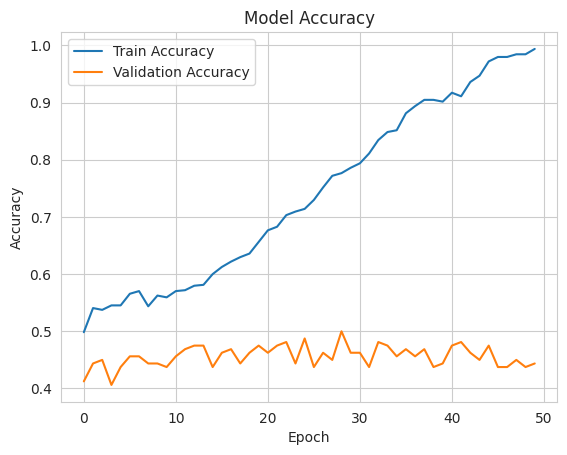

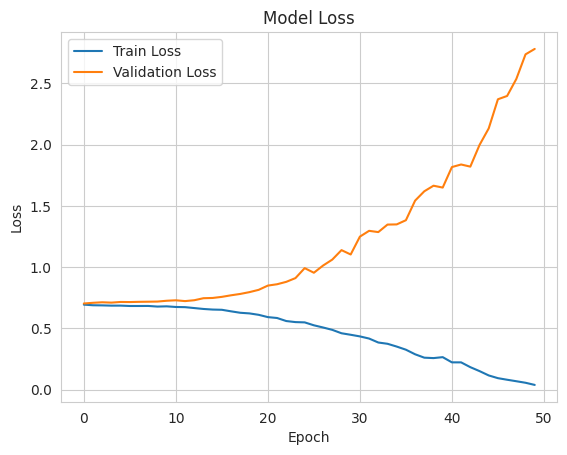

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic data for demonstration
def generate_data(num_samples, timesteps, features):
    # Random data for example purposes
    X = np.random.rand(num_samples, timesteps, features)
    y = np.random.randint(0, 2, num_samples)  # Binary labels
    return X, y

# Parameters
num_samples = 1000  # Number of samples
timesteps = 10      # Number of time steps in each sample
features = 5        # Number of features at each time step

# Generate data
X, y = generate_data(num_samples, timesteps, features)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (optional, depending on your dataset)
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, timesteps * features)
X_test_reshaped = X_test.reshape(-1, timesteps * features)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Create the Sequential model
model = Sequential()

# Input Layer
model.add(Input(shape=(timesteps, features)))

# Add an LSTM layer
model.add(LSTM(units=64, return_sequences=True))

# Add a GRU layer
model.add(GRU(units=32, return_sequences=False))

# Optional: Add a Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plotting training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 10, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,361 (106.88 KB)

 Trainable params: 27,361 (106.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4891 - loss: 0.6950 - val_accuracy: 0.5125 - val_loss: 0.6936
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5137 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5228 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5451 - loss: 0.6886 - val_accuracy: 0.4125 - val_loss: 0.6979
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5409 - loss: 0.6859 - val_accuracy: 0.4563 - val_loss: 0.7030
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5458 - loss: 0.6881 - val_accuracy: 0.4688 - val_loss: 0.7032
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5549 - loss: 0.6895 - val_accuracy: 0.4625 - val_loss: 0.7035
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5340 - loss: 0.6984  
Test Accuracy: 0.5150


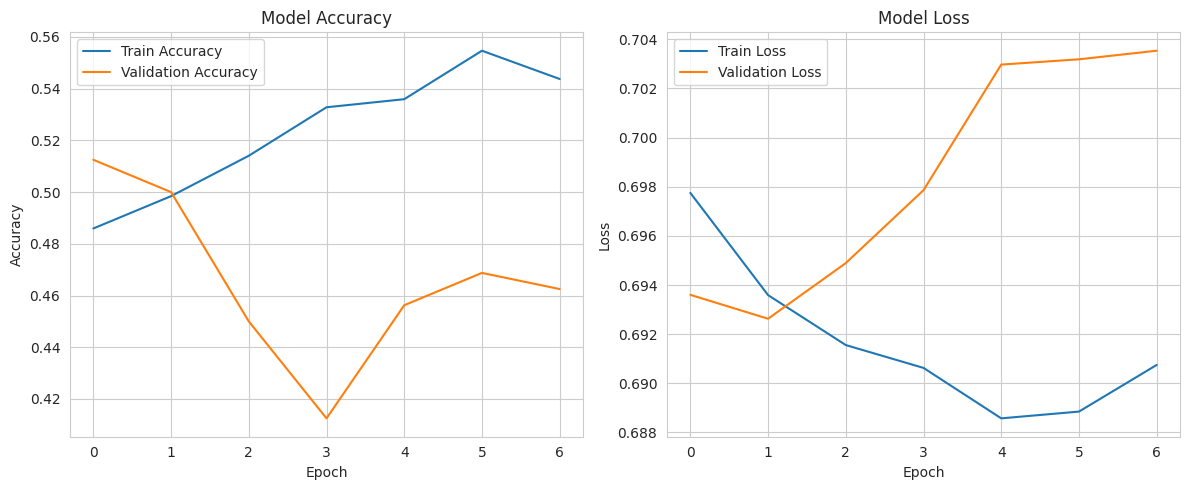

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

# Generate synthetic data for demonstration
def generate_data(num_samples, timesteps, features):
    # Random data for example purposes
    X = np.random.rand(num_samples, timesteps, features)
    y = np.random.randint(0, 2, num_samples)  # Binary labels
    return X, y

# Parameters
num_samples = 1000  # Number of samples
timesteps = 10      # Number of time steps in each sample
features = 5        # Number of features at each time step

# Generate data
X, y = generate_data(num_samples, timesteps, features)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (optional, depending on your dataset)
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, timesteps * features)
X_test_reshaped = X_test.reshape(-1, timesteps * features)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Create the Sequential model
model = Sequential()

# Input Layer
model.add(Input(shape=(timesteps, features)))

# Add an LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))  # Dropout after LSTM

# Add a GRU layer
model.add(GRU(units=32, return_sequences=False))
model.add(Dropout(0.2))  # Dropout after GRU

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plotting training history (optional)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5534 - loss: 0.6900 - val_accuracy: 0.4688 - val_loss: 0.7115
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5828 - loss: 0.6794 - val_accuracy: 0.4750 - val_loss: 0.7233
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5513 - loss: 0.6861 - val_accuracy: 0.4563 - val_loss: 0.7235
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5883 - loss: 0.6786 - val_accuracy: 0.4625 - val_loss: 0.7252
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5579 - loss: 0.6913 - val_accuracy: 0.4875 - val_loss: 0.7130
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5888 - loss: 0.6695 - val_accuracy: 0.4688 - val_loss: 0.7219
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4518 - loss: 0.7011
Test Accuracy: 0.4900


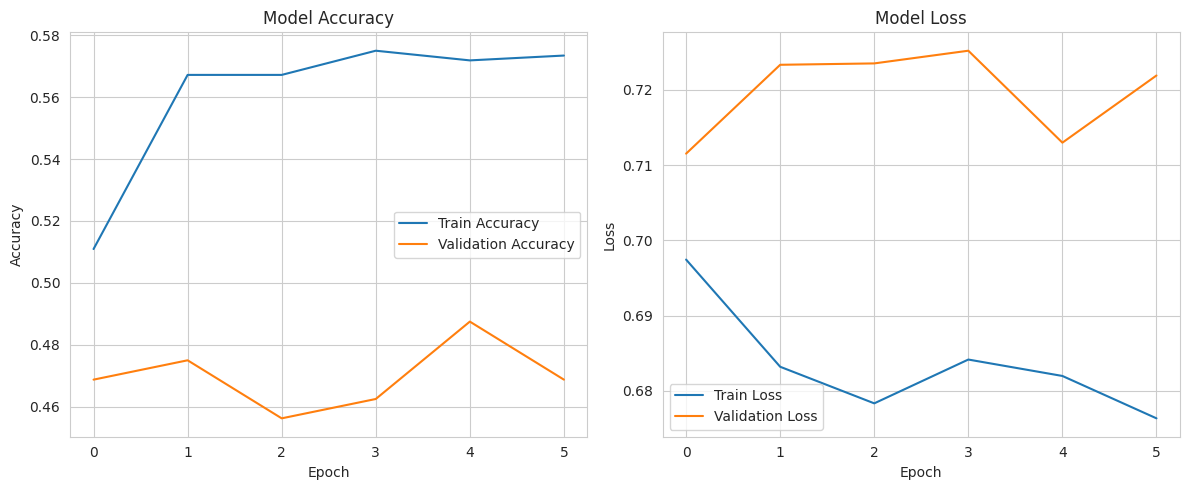

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Input, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

# Generate synthetic data for demonstration
def generate_data(num_samples, timesteps, features):
    X = np.random.rand(num_samples, timesteps, features)
    y = np.random.randint(0, 2, num_samples)  # Binary labels
    return X, y

# Parameters
num_samples = 1000
timesteps = 10
features = 5

# Generate data
X, y = generate_data(num_samples, timesteps, features)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, timesteps * features)
X_test_reshaped = X_test.reshape(-1, timesteps * features)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Create the Sequential model
model = Sequential()

# Input Layer
model.add(Input(shape=(timesteps, features)))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))

# Bidirectional GRU Layer
model.add(Bidirectional(GRU(units=32, return_sequences=False)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
